# TP 5:  

### import libraries 

In [1]:
import os,pickle,time
import numpy                as np
import Hawkes               as hk
import pandas               as pd
import seaborn              as sns
import matplotlib           as mpl
import matplotlib.pyplot    as plt
from   scipy.stats          import kstest

plt.style.use('ggplot')

In [2]:
def plot_KS(T_trans,itv_trans):
    fig, ax = plt.subplots(figsize=(16,6))
    mpl.rc('font', size=12, family='Arial')
    mpl.rc('axes',titlesize=12)
    mpl.rc('pdf',fonttype=42)

    n = len(T_trans)
    [st,en] = itv_trans
    x = np.hstack([st,np.repeat(T_trans,2),en])
    y = np.repeat(np.arange(n+1),2)/n
    w = 1.36/np.sqrt(n)
    [ks_statistic,pvalue] = kstest(T_trans/itv_trans[1],'uniform') # Check if the distribustion is unifrom

    print("Kolmogorov-Smirnov Test:")
    print("KS Statistic:", f'{ks_statistic:.4f}')
    print("p-value:", f'{pvalue:.2%}')
    if pvalue < 0.05:
        print("Reject null hypothesis: Sample does not follow a unifrom distribution")
    else:
        print("Fail to reject null hypothesis: Sample follows a unifrom distribution") 

    ax.plot(x,y,"k-",label='Data')
    ax.fill_between([0,n*w,n*(1-w),n],[0,0,1-2*w,1-w],[w,2*w,1,1],color="#dddddd",label='95% interval')
    ax.set_xlim([0,n])
    ax.set_ylim([0,1])
    ax.set_ylabel("CDF")
    ax.set_xlabel("transfunced time")
    ax.set_title(f"p-value = {pvalue:.2f}")
    ax.legend(loc="upper left")

    plt.show()

def test_goodness_of_fit(sample):
    model = hk.estimator().set_baseline('const').set_kernel('exp')
    T = sample[-1]
    itv = [0,T]
    model.fit(sample,itv)
    [T_trans, itv_trans] = model.t_trans()
    print(f'mu={model.parameter["mu"]:.2f}, alpha={model.parameter["alpha"]:.2f}, beta={model.parameter["beta"]:.2f}')
    print(f"branching ratio: {model.br:.3f}") 
    print(f"log-likelihood: {model.L:.3f}") 
    print(f"AIC: {model.AIC:.3f}") 
    plot_KS(T_trans,itv_trans)

def retrive_events_times(df):
    Jump_times = pd.DataFrame(df['ts'].drop_duplicates().diff().dt.total_seconds())
    Jump_times.dropna(inplace=True)
    Jump_times.rename(columns={'ts':'duration'},inplace=True)
    Jump_times['events'] = Jump_times['duration'].cumsum() 
    Jump_times = Jump_times.reset_index()[['duration','events']]
    return(Jump_times)


Import data

In [3]:
folder_path = './Data/BNPP.PA'
file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and 'trades' in f]

df_trades = pd.DataFrame()
List_df_trades = []
for f in file_names:
    gzip_file_path = folder_path+'/'+f
    df = pd.read_csv(gzip_file_path, compression='gzip',index_col=None)
    del df['Unnamed: 0']
    df['ts'] = pd.to_datetime(df['ts'])
    df = df[df['ts'].dt.hour >= 10]
    List_df_trades.append(df)
    df_trades = pd.concat([df_trades,df])

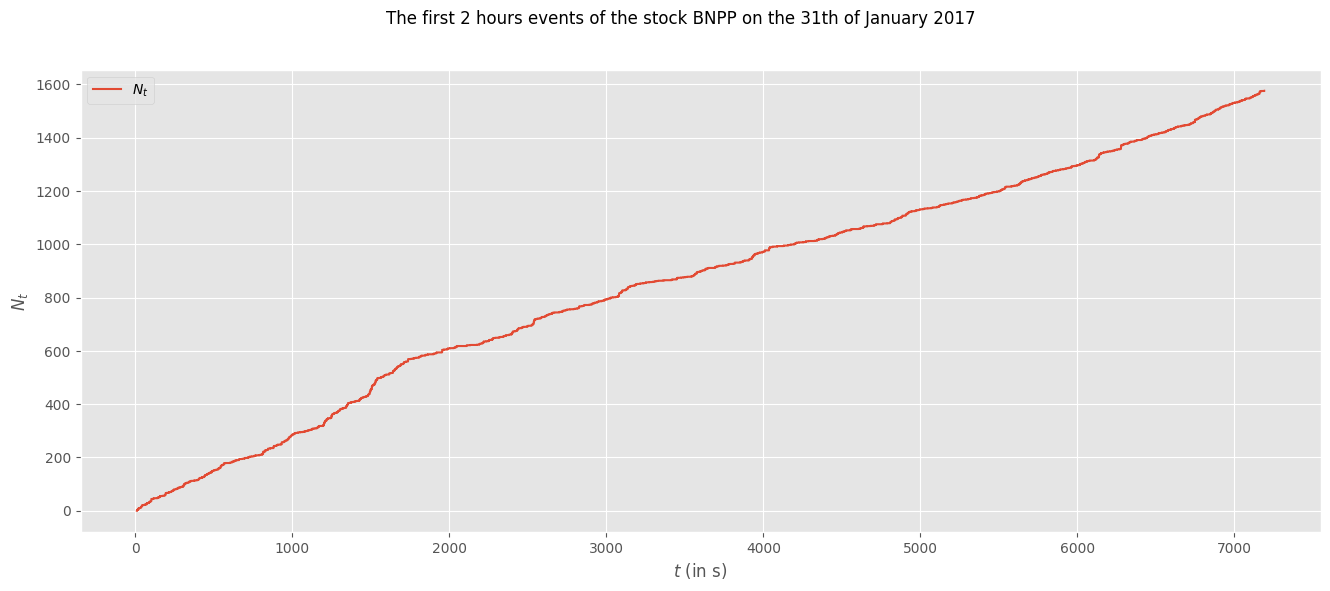

In [4]:
Number_of_hours = 2 #Number of events observed
Jump_times = retrive_events_times(df)
open_Jump_times = Jump_times[Jump_times['events']<=3600*Number_of_hours]

fig, ax = plt.subplots(figsize=(16,6))

fig.suptitle(f'The first {Number_of_hours} hours events of the stock BNPP on the 31th of January 2017')
ax.step(open_Jump_times.events,open_Jump_times.index,label=r'$N_t$',where='pre')

ax.set_xlabel(r'$t$ (in s)')
ax.set_ylabel(r'$N_t$')
ax.legend()

plt.show()

### Question I

#### 1. A first Hawkes fit on empirical data

</br>Select a *typical* day in your trade data and *extract trades from 10:00 to 12:00*. Fit a Hawkes model with a **constant baseline** intensity and a kernel with **one exponential** to this sample. Using the t trans() function of the package, comment on the goodness-of-fit of the model

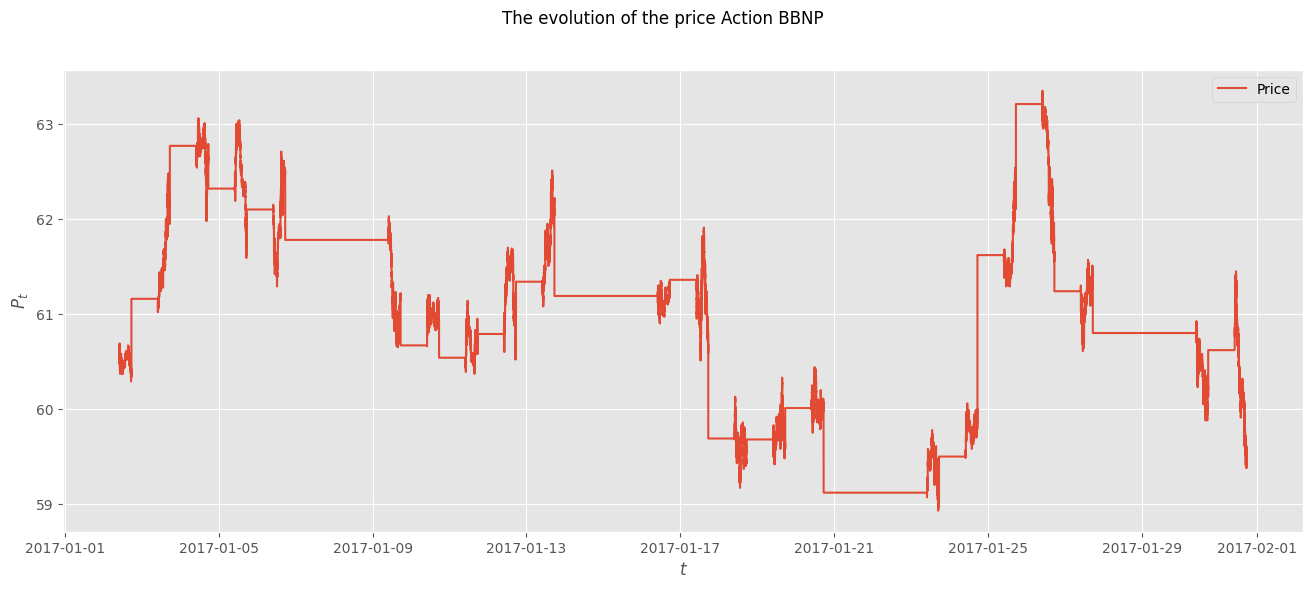

In [5]:
fig, ax = plt.subplots(figsize=(16,6))
fig.suptitle(r'The evolution of the price Action BBNP')

ax.step(df_trades['ts'],df_trades['price'],label=r'Price')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$P_t$')
ax.legend()

plt.show()

We notice that the days 10th, 18th, or 24 seems like typical days since the close price and open price are almost the same. no huge price change

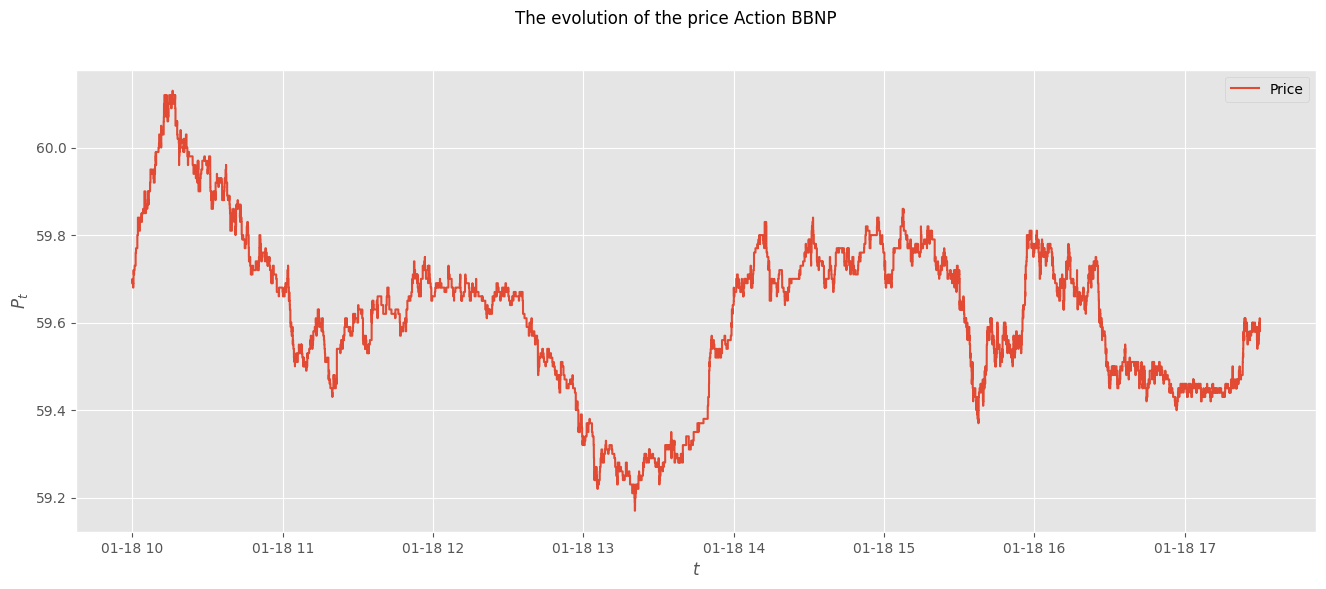

In [6]:
fig, ax = plt.subplots(figsize=(16,6))
fig.suptitle(r'The evolution of the price Action BBNP')

ax.step(List_df_trades[12]['ts'],List_df_trades[12]['price'],label=r'Price')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$P_t$')
ax.legend()

plt.show()

mu=0.11, alpha=0.22, beta=31.37
Kolmogorov-Smirnov Test:
KS Statistic: 0.0486
p-value: 1.59%
Reject null hypothesis: Sample does not follow a unifrom distribution


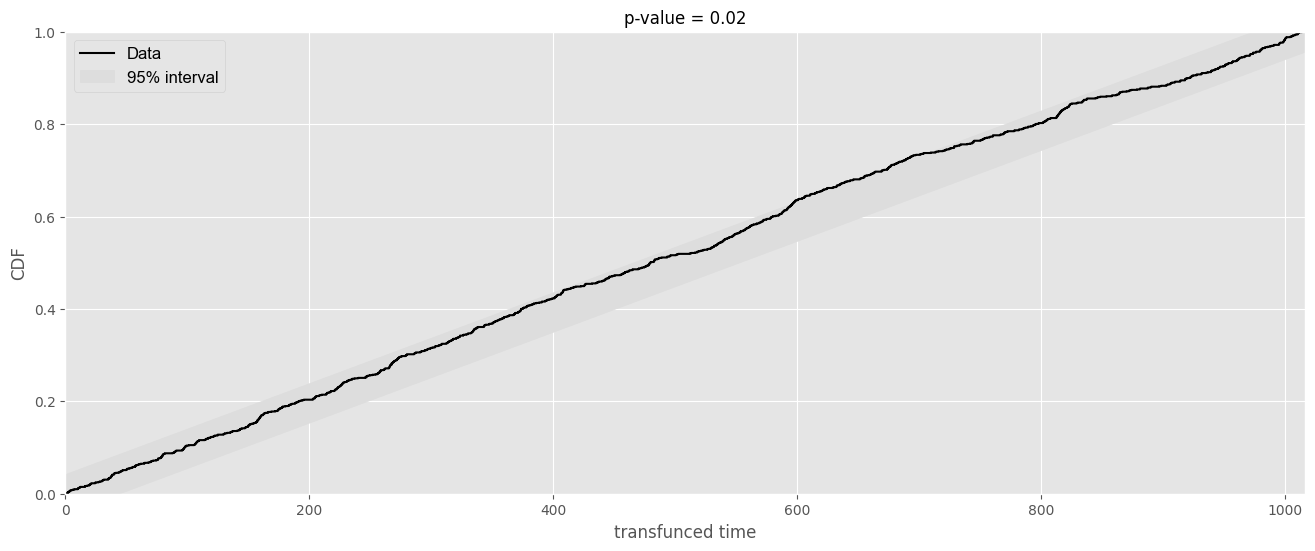

In [7]:
model = hk.estimator()
model.set_kernel('exp')
model.set_baseline('const')

Number_of_hours = 2 #Number of events observed
Jump_times = retrive_events_times(List_df_trades[12])
open_Jump_times = Jump_times[Jump_times['events']<=3600*Number_of_hours]

sample = open_Jump_times['events'].values
T = Number_of_hours*3600

itv = [0,T]
model.fit(sample,itv)
print(f'mu={model.parameter["mu"]:.2f}, alpha={model.parameter["alpha"]:.2f}, beta={model.parameter["beta"]:.2f}')

[T_trans, itv_trans] = model.t_trans()  #a list of transformed event occurrence times, itv_trans: the transformed observation interval
plot_KS(T_trans,itv_trans)

mu=0.11, alpha=0.21, beta=34.30
branching ratio: 0.215
log-likelihood: -2301.189
AIC: 4608.378
Kolmogorov-Smirnov Test:
KS Statistic: 0.0586
p-value: 0.28%
Reject null hypothesis: Sample does not follow a unifrom distribution


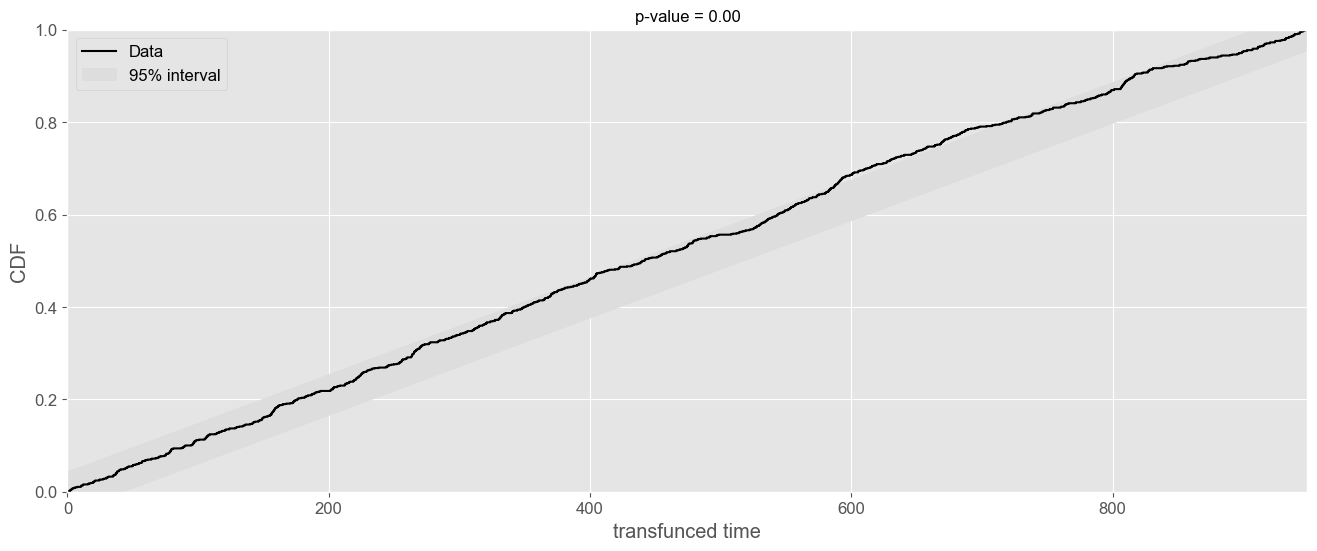

mu=0.04, alpha=0.32, beta=27.71
branching ratio: 0.322
log-likelihood: -3710.541
AIC: 7427.082
Kolmogorov-Smirnov Test:
KS Statistic: 0.4463
p-value: 0.00%
Reject null hypothesis: Sample does not follow a unifrom distribution


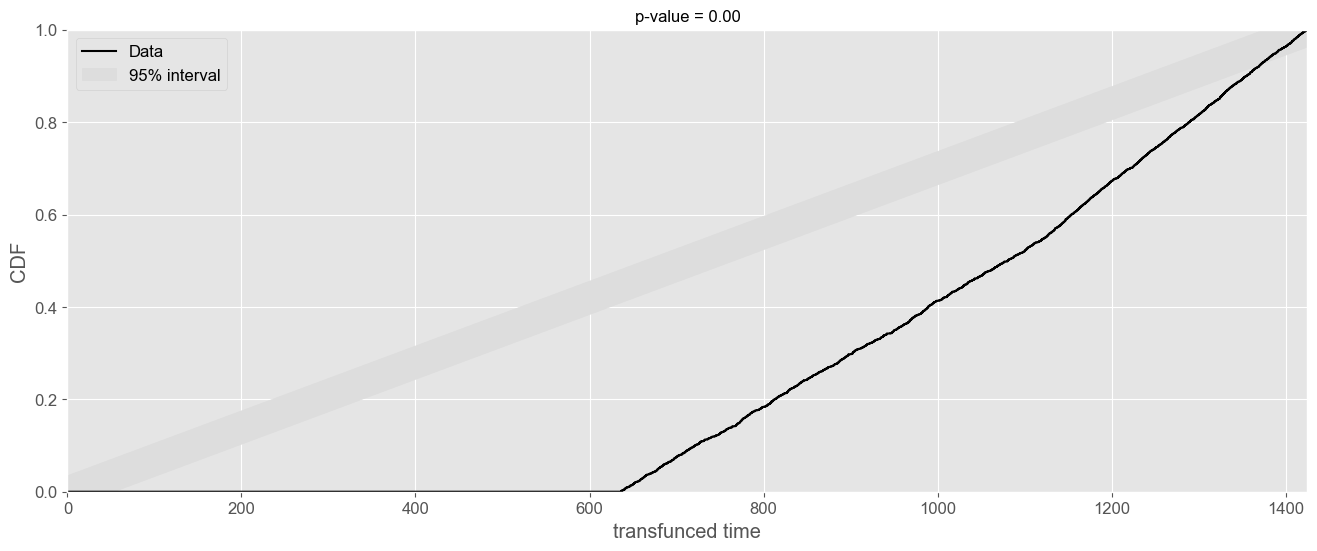

mu=0.00, alpha=1.01, beta=0.07
branching ratio: 1.010
log-likelihood: -2135.347
AIC: 4276.695
Kolmogorov-Smirnov Test:
KS Statistic: 0.0096
p-value: 100.00%
Fail to reject null hypothesis: Sample follows a unifrom distribution


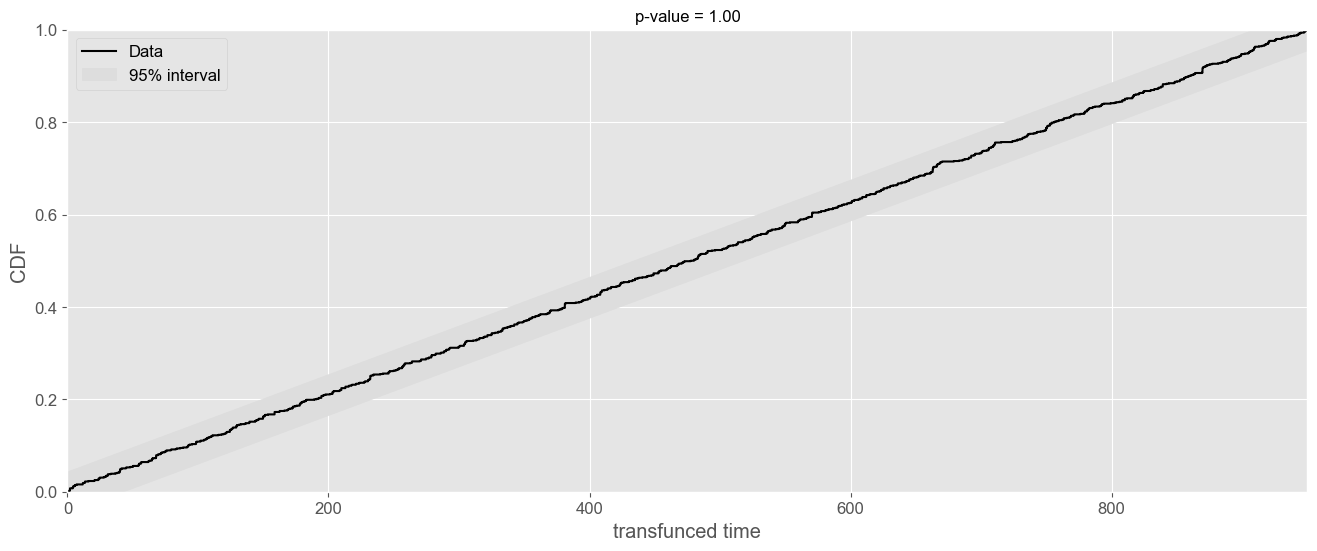

In [8]:
for A,B in [(0,int(len(Jump_times)*0.2)),(int(len(Jump_times)*0.4),int(len(Jump_times)*0.7)),(int(len(Jump_times)*0.8),len(Jump_times))]:
    sample = Jump_times['events'].values[A:B]
    test_goodness_of_fit(sample)

#### 2. Testing different kernels

On the same sample, try fitting different kernels (power-law,multiple exponentials, non-parametric). Compare the fitted kernels. Comment

##### 2.1. multiple exponentials
$f(\tau)=\sum_{i=1}^{num\_exp}\alpha_i \beta_i \exp(-\beta_i \tau)$

mu=0.07,
alpha=[0.11, 0.07, 0.15, 0.16],
beta=[0.56, 8.76, 0.02, 67.94]

Kolmogorov-Smirnov Test:
KS Statistic: 0.0332
p-value: 20.71%
Fail to reject null hypothesis: Sample follows a unifrom distribution


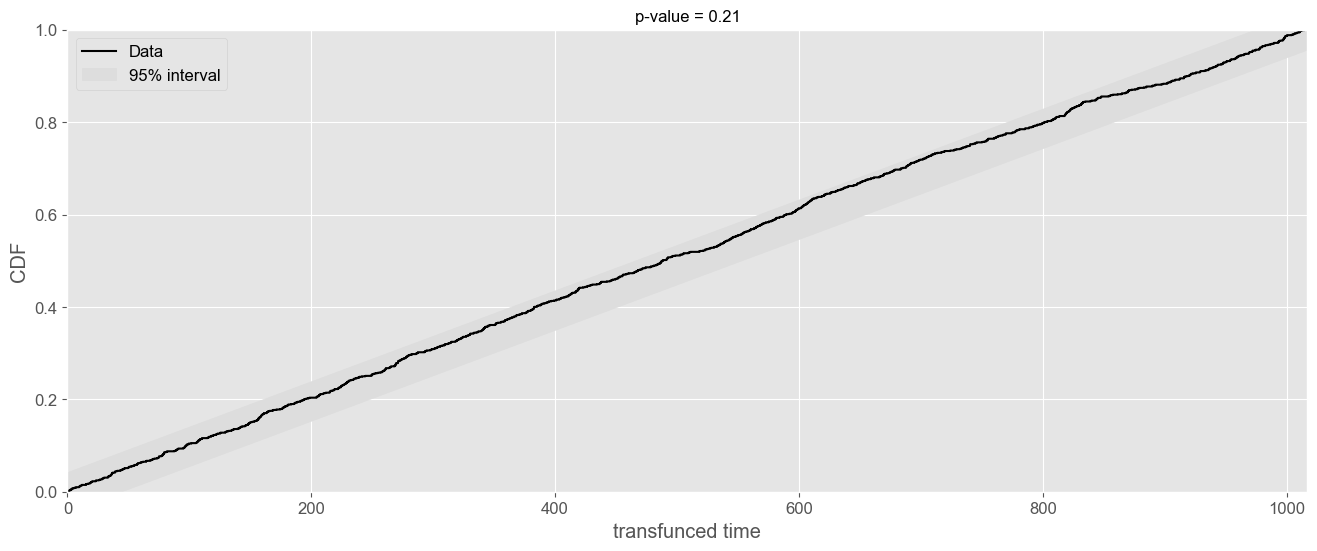

In [9]:
model = hk.estimator()
model.set_kernel('exp',num_exp=4)
model.set_baseline('const')

Number_of_hours = 2 #Number of events observed
Jump_times = retrive_events_times(List_df_trades[12])
open_Jump_times = Jump_times[Jump_times['events']<=3600*Number_of_hours]

sample = open_Jump_times['events'].values
T = Number_of_hours*3600

itv = [0,T]
model.fit(sample,itv)
print(f'mu={model.parameter["mu"]:.2f},\nalpha={[round(a,2) for a in model.parameter["alpha"]]},\nbeta={[round(b,2) for b in model.parameter["beta"]]}\n')

[T_trans, itv_trans] = model.t_trans()
plot_KS(T_trans,itv_trans)

##### 2.2. Power-law
$f(\tau)=k/(\tau+c)^p$

mu=0.09, k=0.03, p=1.31, c=0.01 
Kolmogorov-Smirnov Test:
KS Statistic: 0.0403
p-value: 7.17%
Fail to reject null hypothesis: Sample follows a unifrom distribution


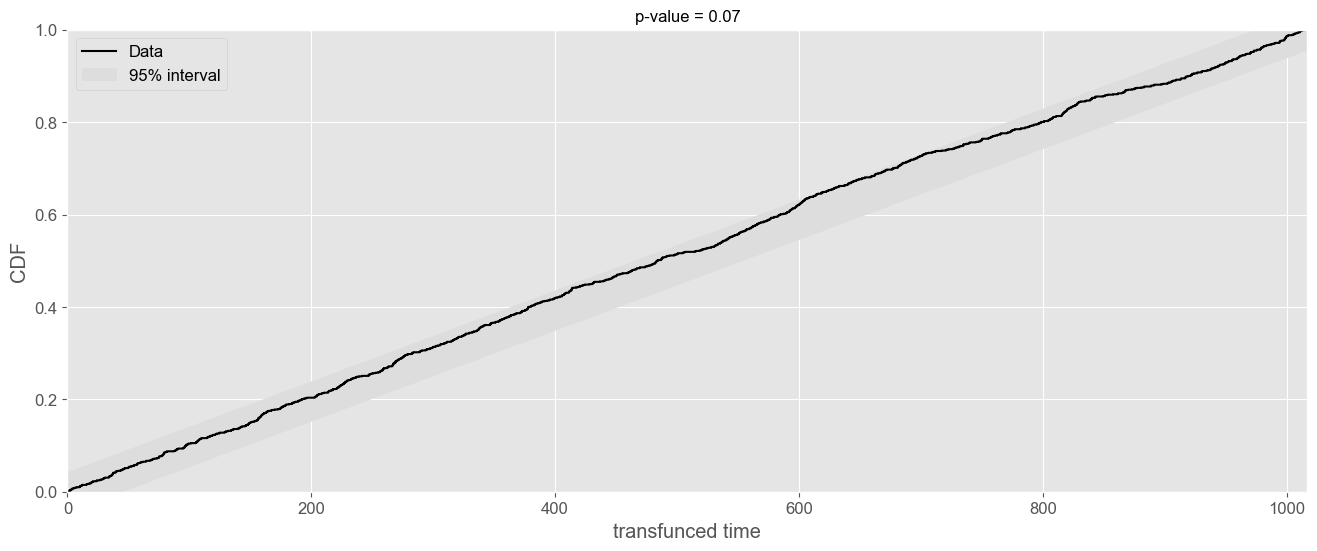

In [10]:
model = hk.estimator()
model.set_kernel('pow')
model.set_baseline('const')

Number_of_hours = 2 #Number of events observed
Jump_times = retrive_events_times(List_df_trades[12])
open_Jump_times = Jump_times[Jump_times['events']<=3600*Number_of_hours]

sample = open_Jump_times['events'].values
T = Number_of_hours*3600

itv = [0,T]
model.fit(sample,itv)
print(f"mu={model.parameter['mu']:.2f}, k={model.parameter['k']:.2f}, p={model.parameter['p']:.2f}, c={model.parameter['c']:.2f} ")

[T_trans, itv_trans] = model.t_trans()
plot_KS(T_trans,itv_trans)

##### 2.3. non-parametric

$f(\tau)=g_i\ ((i-1)L/M < \tau <= iL/M )$ for $i=1,2,\ldots,M$

In [11]:
model = hk.estimator()
model.set_kernel('nonpara',support=1.0,num_bin=32)
model.set_baseline('const')

Number_of_hours = 2 #Number of events observed
Jump_times = retrive_events_times(List_df_trades[12])
open_Jump_times = Jump_times[Jump_times['events']<=3600*Number_of_hours]

sample = open_Jump_times['events'].values
T = Number_of_hours*3600

itv = [0,T]
#model.fit(sample,itv)
#print(f"mu={model.parameter['mu']:.2f}, k={model.parameter['k']:.2f}, p={model.parameter['p']:.2f}, c={model.parameter['c']:.2f} ")
#[T_trans, itv_trans] = model.t_trans()
#plot_KS(T_trans,itv_trans)

Error can not be tarined

#### 3. Systematic analysis.

</br>3.1 For each trading day, fit a Hawkes model with
-  constant or piecewise linear baseline intensity ;
- an exponential kernel with 1, ..., 8 exponentials ;
- on a sample of length 0.25, 0.5, 1, 2, 4, 8 hours.

</br>3.2 For each of these tests, how frequently (how many times out of your 22 trading days) is a statistical test of goodness-of-fit passed ? What would you recommend to a practitionner trying to fit a Hawkes model on trades data ?
</br> **[7] The statistical significance in high-frequency requires multiple exponential kernels for datasets of several hours**

</br>3.1 For each trading day, fit a Hawkes model with
-  constant or piecewise linear baseline intensity 
- an exponential kernel with 1, ..., 8 exponentials
- on a sample of length 0.25, 0.5, 1, 2, 4, 8 hours.

We will save the models in an array with the follwing dimensions:  (Number of days, number of sample length, number of exp kernel components, Number of baselines).

In our case, Number of days = 22, number of sample length = 6, number of exp kernel components= 4, and Number of baselines=2 => dim = (22,6,4,2) 

</br>num_basis=100 -> 26.4 s ± 1.07 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
</br>num_basis=10 -> 31.1 s ± 1.86 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
</br>num_basis=2 -> 2.75 s ± 266 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

For his reason we are going to choose `num_basis` = 2

In [12]:
force_training = False
try:
    if force_training:
        raise Exception
    N = len(List_df_trades)
    num_basis = 2
    scalar = 3600
    hours = [0.25,0.5,1,2,4,6]
    sample_length = [scalar * x for x in hours]
    baselines     = ["const", "plinear"]
    kernel_exp    = [1,2,4,8]
    with open('Models-DRIDI-LAOUEJ.pkl', 'rb') as f:
        models = pickle.load(f)

except:
    N = len(List_df_trades)
    num_basis = 2
    scalar = 3600
    hours = [0.25,0.5,1,2,4,6]
    sample_length = [scalar * x for x in hours]
    baselines     = ["const", "plinear"]
    kernel_exp    = [1,2,4,8]
    models = np.empty((N, len(sample_length), len(kernel_exp), len(baselines)), dtype=hk.model.estimator)

    for i in range(N):
        Jump_times = retrive_events_times(List_df_trades[i])
        for j in range(len(sample_length)):
            sample = Jump_times[Jump_times['events']<=sample_length[j]].events
            T = sample_length[j]
            for k,expon in enumerate(kernel_exp):
                for l,baseline in enumerate(baselines):
                    model = hk.estimator().set_kernel('exp' ,num_exp=expon).set_baseline(baseline) if l== 0 else hk.estimator().set_kernel('exp' ,num_exp=expon).set_baseline(baseline,num_basis=num_basis)
                    model.fit(sample.values,[0,T])
                    models[i,j,k,l]=model

    with open('Models-DRIDI-LAOUEJ.pkl', 'wb') as f:
        pickle.dump(models, f)

Collect data

In [13]:
Number_of_days, number_of_sample_length, number_of_exp_kernel_components, Number_of_baselines = models.shape


parameters = {'p_value':np.empty((Number_of_days, number_of_sample_length, number_of_exp_kernel_components, Number_of_baselines), dtype=float),
              'Branching Ratio':np.empty((Number_of_days, number_of_sample_length, number_of_exp_kernel_components, Number_of_baselines), dtype=float),
              'AIC':np.empty((Number_of_days, number_of_sample_length, number_of_exp_kernel_components, Number_of_baselines), dtype=float)}

for i in range(Number_of_days):
    for j in range(number_of_sample_length):
        for k in range(number_of_exp_kernel_components):
            for l in range(Number_of_baselines):
                model = models[i,j,k,l]
                [T_trans, itv_trans] = model.t_trans()
                [ks_statistic,pvalue] = kstest(T_trans/itv_trans[1],'uniform')
                parameters['Branching Ratio'][i,j,k,l] = model.br 
                parameters['AIC'][i,j,k,l] = model.AIC
                parameters['p_value'][i,j,k,l] = pvalue 



</br>3.2 How frequently is a statistical test of goodness-of-fit passed ?

In [ ]:
print(f"Percentage of models that passed the statistical test of goodness-of-fit:  {np.sum(parameters['p_value']>0.05)/parameters['p_value'].size:.2%}")

Percentage of models that passed the statistical test of goodness-of-fit:  50.85%


In [ ]:
data = pd.DataFrame({'Kernal size':[1,2,4,8],'Percentage passed' :100*np.sum(parameters['p_value']>0.05,axis=(0,1,3))*number_of_exp_kernel_components/parameters['p_value'].size},)
data = data.set_index('Kernal size')
data.T.round(2)

Kernal size,1,2,4,8
Percentage passed,42.05,47.73,55.3,58.33


In [ ]:
data = pd.DataFrame({'sample length':hours,'Percentage passed' :100*np.sum(parameters['p_value']>0.05,axis=(0,2,3))*number_of_sample_length/parameters['p_value'].size},)
data = data.set_index('sample length')
data.T.round(2)

sample length,0.25,0.50,1.00,2.00,4.00,6.00
Percentage passed,92.05,81.82,63.64,36.93,16.48,14.2


In [ ]:
data = pd.DataFrame({'baseline':["const", "plinear"],'Percentage passed' :100*np.sum(parameters['p_value']>0.05,axis=(0,1,2))*Number_of_baselines/parameters['p_value'].size},)
data = data.set_index('baseline')
data.T.round(2)

baseline,const,plinear
Percentage passed,40.15,61.55


</br>[7] finds that statistical significance in high-frequency requires multiple exponential kernels for datasets of several hours

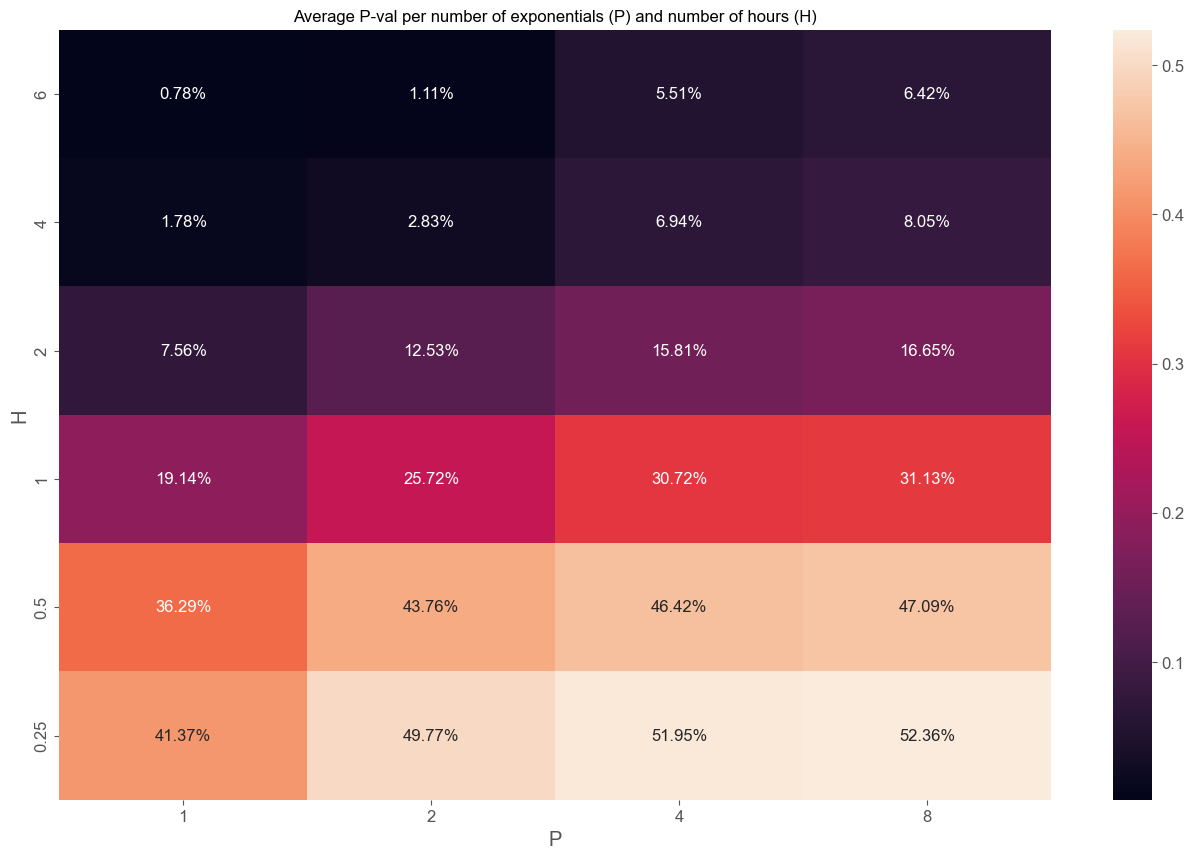

In [ ]:
data = np.mean(parameters['p_value'],axis=(0,3))

plt.figure(figsize=(16, 10))
sns.heatmap(np.flip(data,axis=0), annot=True, fmt=".2%", xticklabels=kernel_exp, yticklabels=hours[::-1]) #cmap='viridis'
plt.title(r'Average P-val per number of exponentials (P) and number of hours (H)')
plt.xlabel(r'P')
plt.ylabel(r'H')
plt.show()

**Comments**

We notice that for several hours the avergae P-val is low $<6.25 %$ even for high number of exponential components. However, If still delevers statistically significance in high-frequency for multiple exponential kernels.


 
What would you recommend to a practitionner trying to fit a Hawkes model on trades data ?

AIC stands for Akaike Information Criterion. It's a measure used for model selection among a set of candidate models. The basic idea behind AIC is to balance the goodness of fit of the model with its complexity, penalizing models that are too complex. AIC is calculated using the formula:

$ AIC = -2 \times \text{log-likelihood} + 2 \times \text{number of parameters} $

Where:
- Log-likelihood is the maximum value of the log-likelihood function achieved by the model.
- Number of parameters is the count of parameters estimated by the model.

The goal is to select the model with the lowest AIC value because it indicates the best compromise between goodness of fit and complexity. 


Here's how you can use AIC to deduce the number of exponentials selected:

1. Fit the Hawkes model with different numbers of exponentials, varying `expon`.
2. Calculate the AIC for each model.
3. Choose the model with the lowest AIC.
4. The number of exponentials corresponding to the model with the lowest AIC is considered optimal.


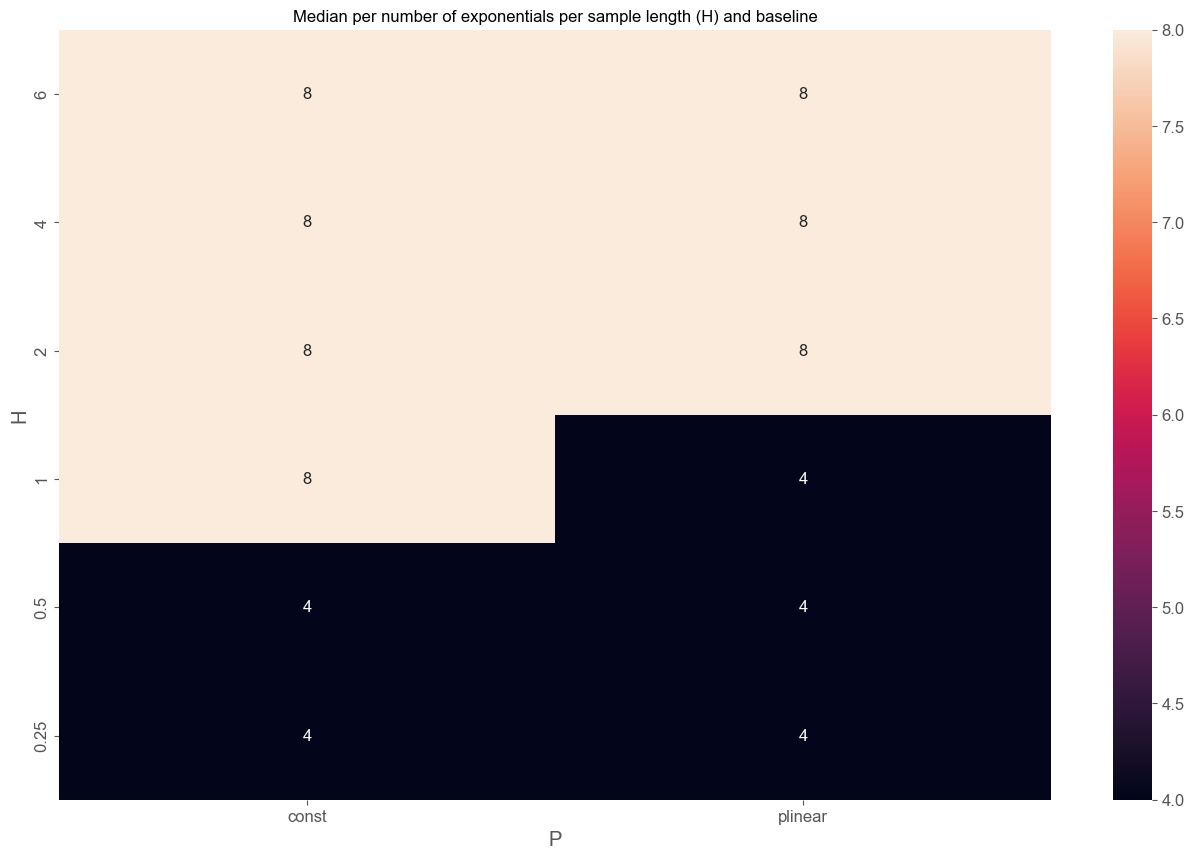

In [ ]:
#Use min instead
data = np.median(np.argmin(parameters['AIC'],axis=2),axis=(0))
best_number = np.flip(data,axis=0)
for i in range(best_number.shape[0]):
    for j in range(best_number.shape[1]):
        best_number[i,j] = kernel_exp[int(best_number[i,j])]



plt.figure(figsize=(16, 10))
sns.heatmap(best_number, annot=True, fmt=".0f", xticklabels=baselines, yticklabels=hours[::-1]) #cmap='viridis'
plt.title(r'Median per number of exponentials per sample length (H) and baseline')
plt.xlabel(r'P')
plt.ylabel(r'H')
plt.show()

#### 4. Computational time

 For several types of kernels, simulate a sample with N events and
estimate a Hawkes model (with the appropriate kernel choice) on this sample. For each
kernel, plot the computational time of the estimation with respect to N. Comment.


##### 4.1. exp kernal with constant baseline

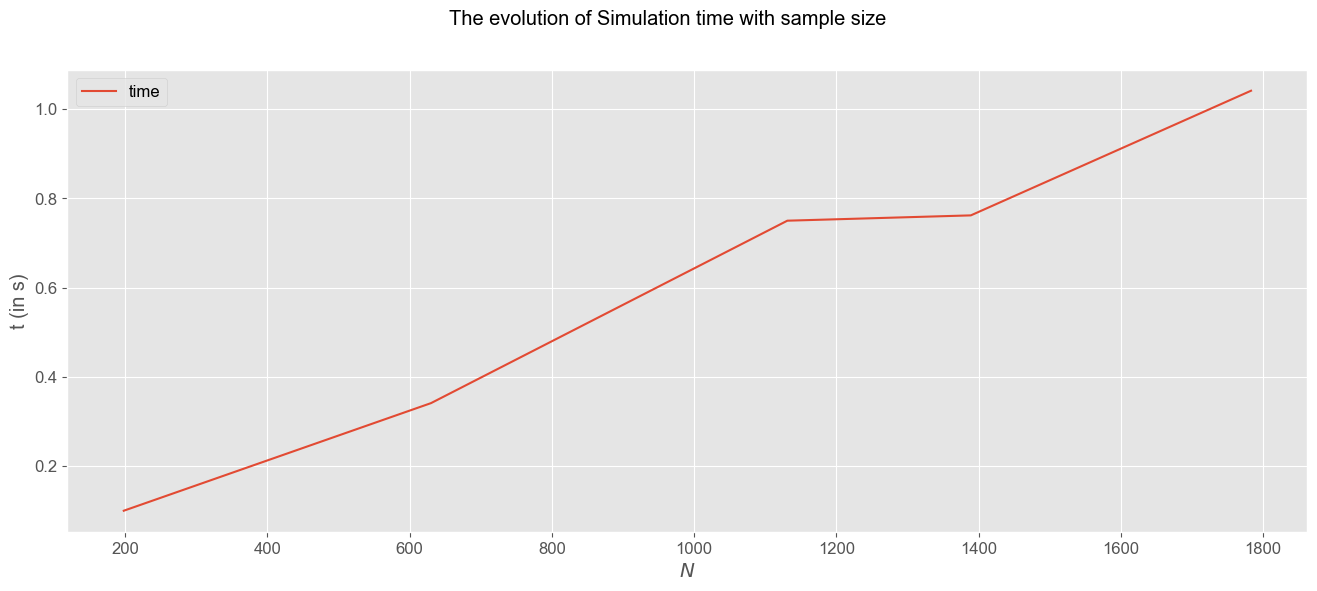

In [37]:
numb_sim = 25
list_t = np.arange(1000,10001,2000)

simulator_model = hk.simulator().set_kernel('exp').set_baseline('const')
para = {'mu':0.1, 'alpha':0.5, 'beta':10.0}
simulator_model.set_parameter(para)

data = {}
for T in list_t:
    itv = [0,T] # the observation interval
    Jumps = simulator_model.simulate(itv)
    data[T] = {'simuation':Jumps,'sample':len(Jumps)}

for key,value in data.items():
    estimator_model = hk.estimator().set_kernel('exp').set_baseline('const')
    data[key]['time']=0
    for _ in range(numb_sim):
        start_time = time.time()
        estimator_model.fit(value['simuation'],[0,key])
        end_time = time.time()
        data[key]['time'] += end_time - start_time
    data[key]['time'] = data[key]['time']/numb_sim

fig, ax = plt.subplots(figsize=(16,6))
fig.suptitle(r'The evolution of Simulation time with sample size')
times = [value['time'] for value in data.values()]
sample = [value['sample'] for value in data.values()]

zipped_lists = zip(sample, times)
sorted_zipped_lists = sorted(zipped_lists)
sample, times = zip(*sorted_zipped_lists)

ax.plot(sample,times,label=r'time')
ax.set_xlabel(r'$N$')
ax.set_ylabel(r't (in s)')
ax.legend()

plt.show()

##### 4.2. multiple exp kernal (p=2) with constant baseline

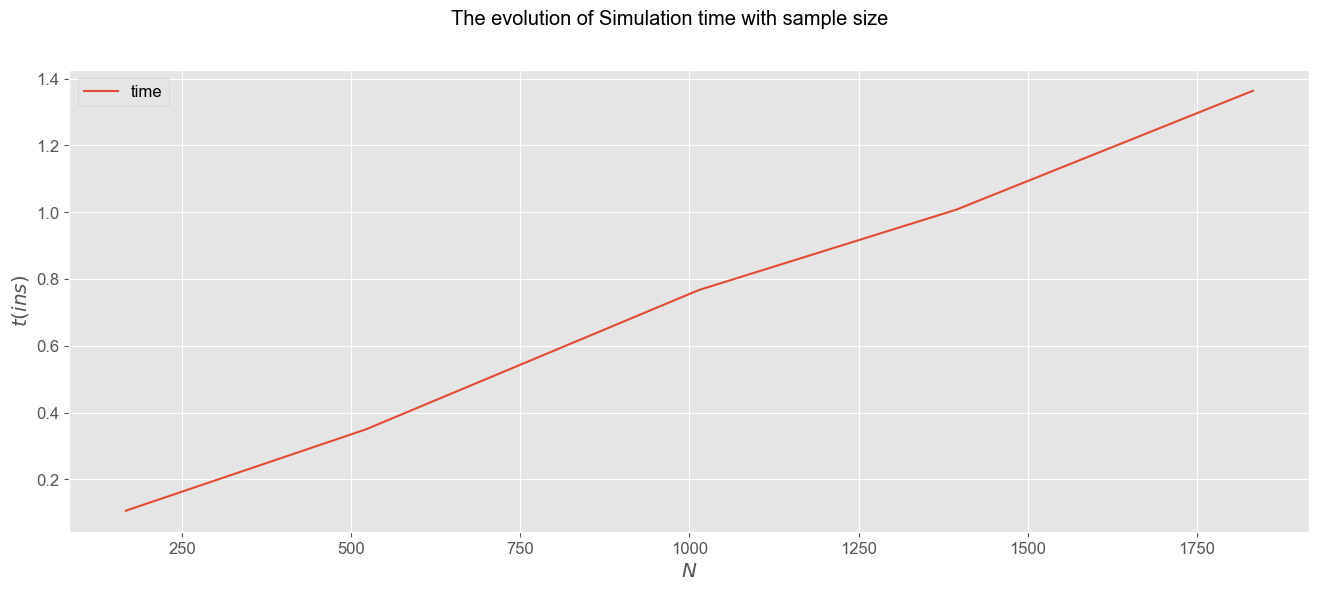

In [39]:
list_t = np.arange(1000,10001,2000)
numb_sim = 25

simulator_model = hk.simulator().set_kernel('exp',num_exp=2).set_baseline('const')
para = {'mu':0.1, 'alpha':[0.1,0.4], 'beta':[1.0,10.0]}
simulator_model.set_parameter(para)

data = {}
for T in list_t:
    itv = [0,T] # the observation interval
    Jumps = simulator_model.simulate(itv)
    data[T] = {'simuation':Jumps,'sample':len(Jumps)}

for key,value in data.items():
    estimator_model = hk.estimator().set_kernel('exp',num_exp=2).set_baseline('const')
    data[key]['time']=0
    for _ in range(numb_sim):
        start_time = time.time()
        estimator_model.fit(value['simuation'],[0,key])
        end_time = time.time()
        data[key]['time'] += end_time - start_time
    data[key]['time'] = data[key]['time']/numb_sim

fig, ax = plt.subplots(figsize=(16,6))
fig.suptitle(r'The evolution of Simulation time with sample size')
times = [value['time'] for value in data.values()]
sample = [value['sample'] for value in data.values()]

zipped_lists = zip(sample, times)
sorted_zipped_lists = sorted(zipped_lists)
sample, times = zip(*sorted_zipped_lists)

ax.plot(sample,times,label=r'time')
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$t (in s)$')
ax.legend()

plt.show()

##### 4.3. power-law with constant baseline

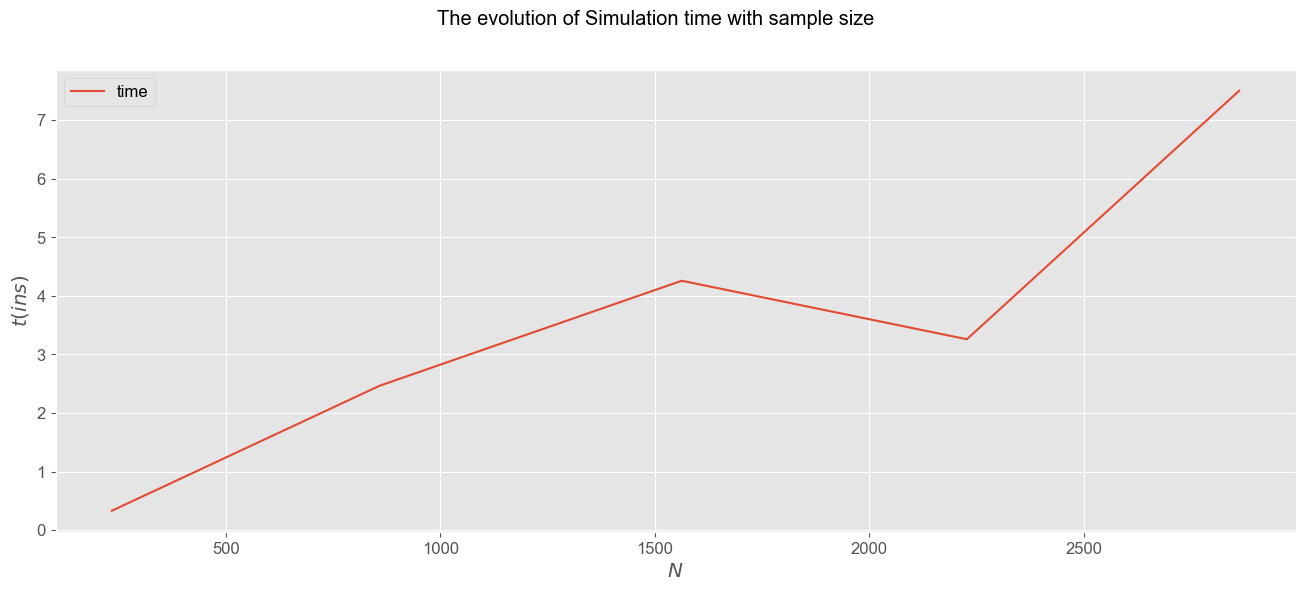

In [38]:
list_t = np.arange(1000,10001,2000)
numb_sim = 25

simulator_model = hk.simulator().set_kernel('pow').set_baseline('const')
para = {'mu':0.1,'k':0.8, 'p':1.5, 'c':5.0}
simulator_model.set_parameter(para)

data = {}
for T in list_t:
    itv = [0,T] # the observation interval
    Jumps = simulator_model.simulate(itv)
    data[T] = {'simuation':Jumps,'sample':len(Jumps)}

for key,value in data.items():
    estimator_model = hk.estimator().set_kernel('pow').set_baseline('const')
    data[key]['time']=0
    for _ in range(numb_sim):
        start_time = time.time()
        estimator_model.fit(value['simuation'],[0,key])
        end_time = time.time()
        data[key]['time'] += end_time - start_time
    data[key]['time'] = data[key]['time']/numb_sim

fig, ax = plt.subplots(figsize=(16,6))
fig.suptitle(r'The evolution of Simulation time with sample size')
times = [value['time'] for value in data.values()]
sample = [value['sample'] for value in data.values()]

zipped_lists = zip(sample, times)
sorted_zipped_lists = sorted(zipped_lists)
sample, times = zip(*sorted_zipped_lists)

ax.plot(sample,times,label=r'time')
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$t (in s)$')
ax.legend()

plt.show()